<a href="https://colab.research.google.com/github/YanivAmir/Ride-Hailing-Demand-Forecast/blob/main/PriceActionCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
!pip install --upgrade --no-cache-dir git+https://github.com/rongardF/tvdatafeed.git
!pip install yahoo_fin
!pip install mplfinance

  Cloning https://github.com/rongardF/tvdatafeed.git to /tmp/pip-req-build-azfyi3t9
  Running command git clone --filter=blob:none --quiet https://github.com/rongardF/tvdatafeed.git /tmp/pip-req-build-azfyi3t9
  Resolved https://github.com/rongardF/tvdatafeed.git to commit e6f6aaa7de439ac6e454d9b26d2760ded8dc4923
  Preparing metadata (setup.py) ... done


In [44]:
from tvDatafeed import TvDatafeed, Interval #pip install --upgrade --no-cache-dir git+https://github.com/rongardF/tvdatafeed.git
import yfinance as yf
import yahoo_fin.stock_info as si
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import random
import mplfinance as mpf
from datetime import datetime
from collections import Counter
import pandas as pd #pip install pandas==1.3.0
import numpy as np
import pickle
from sklearn.preprocessing import MinMaxScaler
import logging
import re
from google.colab import drive
drive.mount('/content/drive')
#tv = TvDatafeed("janivamir","Tyrion12tv!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
savePath ='/content/drive/MyDrive/myStocksSept2024/'
with open(savePath+'TVstockData_NASDAQ_all_4803_18-20Sept2024.pickle', 'rb') as file:
        nasdaq_data = pd.read_pickle(file)
with open(savePath+'TVstockData_NYSE_all_6293_17Sept2024.pickle', 'rb') as file:
        nyse_data = pd.read_pickle(file)
data = { **nasdaq_data,**nyse_data}
print(len(data))

5850


In [46]:
nyse_tickers = si.tickers_other()
nasdaq_tickers = si.tickers_nasdaq()
tickers = nasdaq_tickers + nyse_tickers

Text(0.5, 1.0, 'Distribution of first date of data')

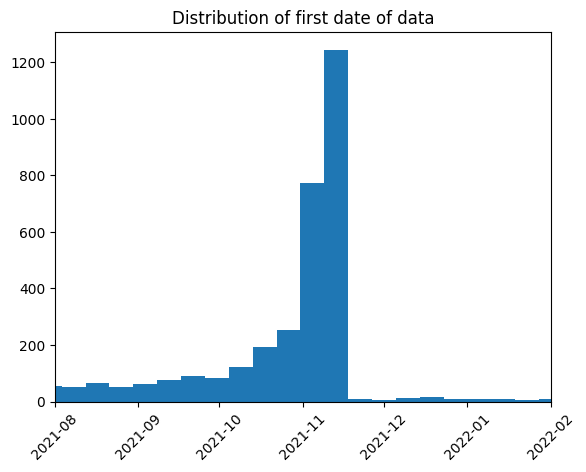

In [47]:
dates= [data[k].index[0] for k in data]
plt.hist(dates,bins=1000)
plt.xlim((datetime(2021,8,1),datetime(2022,2,1)))
plt.xticks(rotation=45)
plt.title('Distribution of first date of data')


In [48]:
from dateutil.relativedelta import relativedelta

# Count occurrences of each date
date_counts = Counter(dates)

# Find the most common date
mode_date, mode_count = date_counts.most_common(1)[0]
print(sum([1 for date in dates if date>mode_date]))
print("Mode date:", mode_date)
print("Count of mode date:", mode_count)

1447
Mode date: 2021-11-09 20:30:00
Count of mode date: 328


Text(0.5, 1.0, 'Distribution of last date of data')

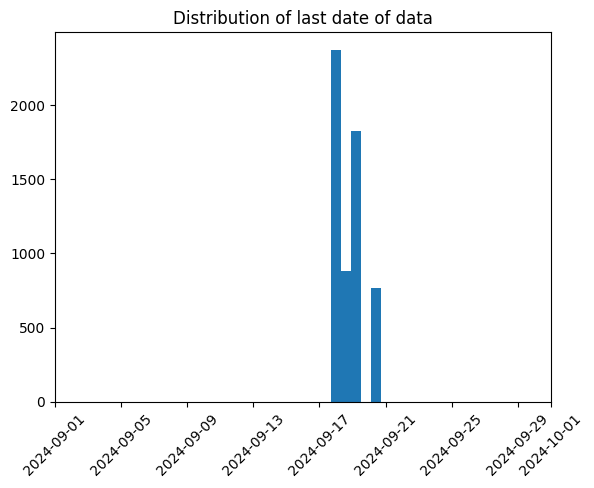

In [49]:
dates= [data[k].index[-1] for k in data]
plt.hist(dates,bins=5)
plt.xlim((datetime(2024,9,1),datetime(2024,10,1)))
plt.xticks(rotation=45)
plt.title('Distribution of last date of data')

In [50]:
from dateutil.relativedelta import relativedelta

# Count occurrences of each date
date_counts = Counter(dates)

# Find the most common date
mode_date, mode_count = date_counts.most_common(1)[0]
print(sum([1 for date in dates if date>mode_date]))
print("Mode date:", mode_date)
print("Count of mode date:", mode_count)

769
Mode date: 2024-09-18 22:30:00
Count of mode date: 1829


In [107]:
lengths = []
capDayMean = []
capHrMean = []
shortTickers=[]
# Assuming data[ticker] is a DataFrame with a DateTimeIndex
start_date = datetime(2021, 11, 9).date()
end_date = datetime(2024, 9, 17).date()

# Filter the DataFrame based on the date range
for i,ticker in enumerate(data):
  data[ticker] = data[ticker][(data[ticker].index.date >= start_date) & (data[ticker].index.date <= end_date)]
  lengths.append(len(data[ticker]))
  if lengths[-1]<2500:
    shortTickers.append(ticker)
  capDayMean.append(data[ticker].cap.resample('D').sum().mean())
  capHrMean.append(data[ticker].cap.mean())
  if i%500==0:
    print(i,end=' ')

0 500 1000 1500 2000 2500 3000 3500 4000 4500 5000 5500 

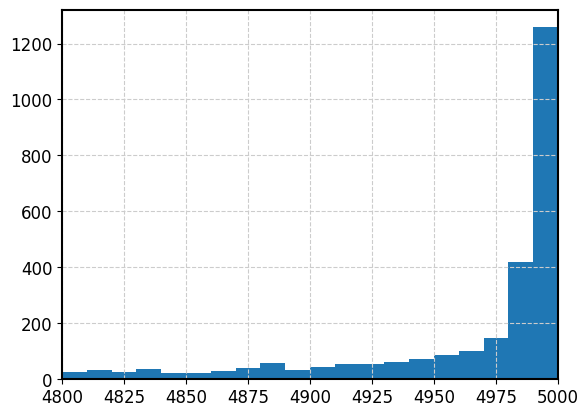

1426


In [108]:
plt.hist(lengths,bins=500)
plt.xlim(4800,5000)
plt.show()
print(sum([1 for len in lengths if len<3000]))


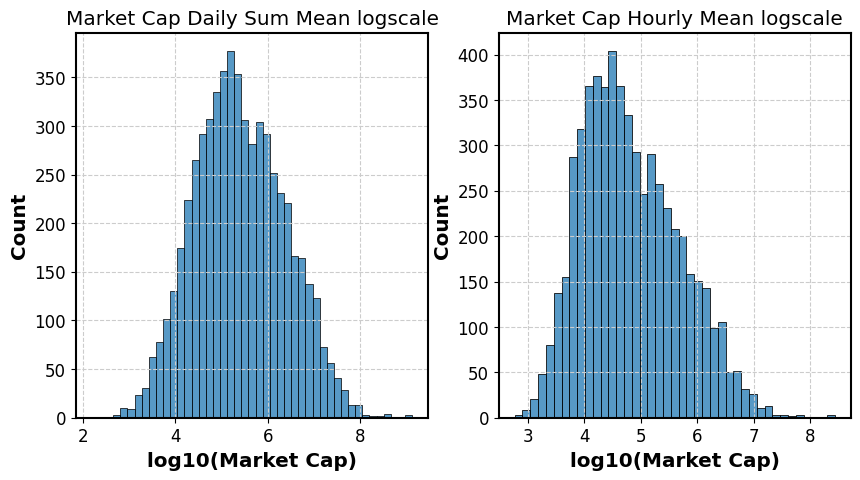

In [118]:
import seaborn as sns

fig,ax = plt.subplots(1,2,figsize=(10,5))
sns.histplot(np.log10(capDayMean), ax = ax[0])
sns.histplot(np.log10(capHrMean), ax = ax[1])
ax[0].set_title('Market Cap Daily Sum Mean logscale')
ax[1].set_title('Market Cap Hourly Mean logscale')
ax[0].set_xlabel('log10(Market Cap)')
ax[1].set_xlabel('log10(Market Cap)')
plt.show()

In [115]:

posTickers = [ticker for ticker in data if len(data[ticker])>4500 and np.log10(data[ticker].cap.mean())>4.15 and np.log10(data[ticker].cap.resample('D').sum().mean())>5]
print(len(posTickers)/len(data))

0.5029059829059829


In [ ]:
from copy import deepcopy
import warnings
import time
warnings.filterwarnings('ignore')


scaledDF = deepcopy(data[ticker])
scaledDF = scaledDF.iloc[:,1:5]

st = 5 #stride in days
rng = 90 #dataRange in days
prd = 10 #predictionPeriod in days
h4d = 7
targetBuffer = 10 #time periods
minRelativePriceMove = 0.1
dpi = 64
figsize = (5, 5)
nTickers= 10
nPics4Ticker = 110

nTotalPics = nTickers*nPics4Ticker
imageData = np.zeros((nTotalPics,dpi*figsize[0],dpi*figsize[0],2))

fig1, ax1 = plt.subplots(figsize=figsize,dpi=dpi)

fig2, ax2 = plt.subplots(figsize=figsize,dpi=dpi)


count = 0
indicesNotUsed=[]
start_time = time.time()
for j,ticker in enumerate(list(data.keys())[300:300+nTickers]):
  print(ticker)
  labels = np.array(data[ticker].close[435:]/data[ticker].close[4:len(data[ticker])-431].values-1)
  xaxis_close = np.linspace(0,len(data[ticker])-1-431,len(data[ticker])-431)
  xaxis_labels = np.linspace(0,len(labels)-1,len(labels))

  # Extract the volume data and corresponding dates
  volume_data = data[ticker]['cap'].values
  volume_dates = data[ticker].index


  #fig, axs = plt.subplots(12,10,figsize=(15,9), dpi=64) #120 for ALL time points, need to remove last ten so as to not to contaminate when testing

  for i in range(nPics4Ticker):
    target = np.mean(labels[i*h4d*st+h4d*rng+h4d*prd-targetBuffer:i*h4d*st+h4d*rng+h4d*prd+targetBuffer]) #stride + dataRange+ predictionPeriod +-1day (=20 hours)
    if target>minRelativePriceMove or target<-minRelativePriceMove:
      count+=1
      #print(target)
      scaler = MinMaxScaler()
      scaledDF.iloc[:,:] = scaler.fit_transform(data[ticker].iloc[:,1:5].values)
      # Plot on the primary y-axis
      priceFix = 0.5/scaledDF.iloc[i*h4d*st,0] #to make the first opening value to be 0.5
      scaledDF *= priceFix

      # Plot the OHLC chart without volume
      ax1.clear()
      mpf.plot(scaledDF.iloc[i*h4d*st:h4d*rng+h4d*st*i,:],
              type='ohlc',
              ax=ax1,
              volume=False,
              style='classic',
              show_nontrading=True)

      # Customize Plot 1: Remove gridlines, ticks, and borders
      # ax1.axis('off')
      ax1.set_ylim(0.1,1.1)
      ax1.xaxis.set_visible(False)
      ax1.yaxis.set_visible(False)
      ax1.spines['top'].set_visible(False)
      ax1.spines['bottom'].set_visible(False)
      ax1.spines['left'].set_visible(False)
      ax1.spines['right'].set_visible(False)
      #plt.show()


      fig1.canvas.draw()
      rgba_array = np.frombuffer(fig1.canvas.tostring_argb(), dtype=np.uint8).reshape((figsize[0]*dpi, figsize[0]*dpi, 4))
      #grey_array = 0.2989 * rgba_array[..., 0] + 0.5870 * rgba_array[..., 1] + 0.1140 * rgba_array[..., 2]
      imageData[j,:,:,0] = (0.2989 * rgba_array[..., 0] + 0.5870 * rgba_array[..., 1] + 0.1140 * rgba_array[..., 2])/255
      # plt.imshow(grey_array,cmap='gray')
      # plt.show()


      # Plot 2: Volume Only (with matplotlib)
      ax2.clear()
      ax2.bar(volume_dates[i*h4d*st:h4d*rng+h4d*st*i], volume_data[i*h4d*st:h4d*rng+h4d*st*i], color='black', width=0.75)

      # Customize Plot 2: Remove gridlines, ticks, and borders

      #ax2.axis('off')
      ax2.set_ylim(0,np.max(volume_data[i*h4d*st:h4d*rng+h4d*st*i]))
      ax2.set_title(int(np.max(volume_data[i*h4d*st:h4d*rng+h4d*st*i])),fontsize=10)
      ax2.xaxis.set_visible(False)
      ax2.yaxis.set_visible(False)
      ax2.spines['top'].set_visible(False)
      ax2.spines['bottom'].set_visible(False)
      ax2.spines['left'].set_visible(False)
      ax2.spines['right'].set_visible(False)

      #plt.show()

      fig2.canvas.draw()
      rgba_array = np.frombuffer(fig2.canvas.tostring_argb(), dtype=np.uint8).reshape((figsize[0]*dpi, figsize[0]*dpi, 4))
      #grey_array = 0.2989 * rgba_array[..., 0] + 0.5870 * rgba_array[..., 1] + 0.1140 * rgba_array[..., 2]
      imageData[j,:,:,1] = (0.2989 * rgba_array[..., 0] + 0.5870 * rgba_array[..., 1] + 0.1140 * rgba_array[..., 2])/255

      if count%100 ==0:
        print(count,': ',time.time()-start_time)
  else:
    indicesNotUsed.append(i)
print('10 tickers : ',time.time()-start_time)

/usr/local/lib/python3.10/dist-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


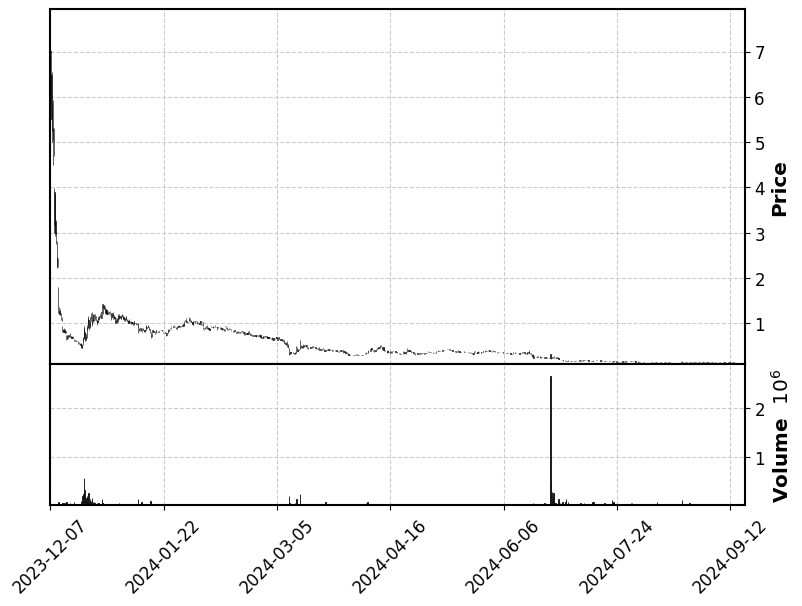

In [91]:
mpf.plot(data[shortTickers[0]],
         type='candle',
         volume=True,
         style='classic',
         datetime_format='%Y-%m-%d',  # Format for dates
         xrotation=45,                # Rotate date labels for readability
         tight_layout=True)

In [103]:
len(data)- sum([1 for cap in capMean if cap<10**4.5] # 10^4.5 is 30K $ per hr ~ 220K & per day

3502

In [96]:
sum([1 for cap in capSum if cap<10**7.5])

1252

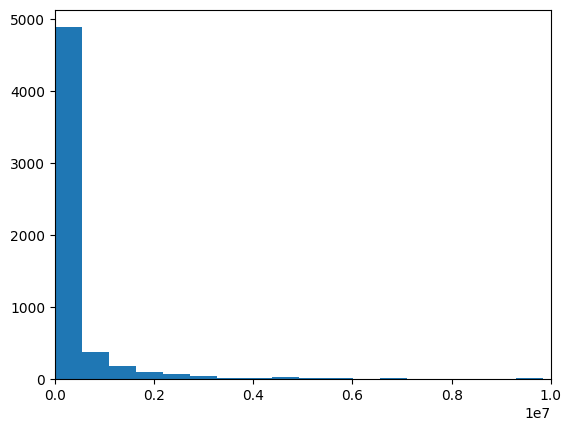

In [76]:
plt.hist(capMean,bins=500)
plt.xlim(0,10**6)
plt.show()

In [25]:
from dateutil.relativedelta import relativedelta

# Count occurrences of each date
date_counts = Counter(dates)

# Find the most common date
mode_date, mode_count = date_counts.most_common(1)[0]
print(sum([1 for date in dates if date>mode_date]))
print("Mode date:", mode_date)
print("Count of mode date:", mode_count)

1447
Mode date: 2021-11-09 20:30:00
Count of mode date: 328


338


(array([  0.,   0.,   0.,   0.,   0., 338.,   0.,   0.,   0.,   0.]),
 array([4999.5, 4999.6, 4999.7, 4999.8, 4999.9, 5000. , 5000.1, 5000.2,
        5000.3, 5000.4, 5000.5]),
 <BarContainer object of 10 artists>)

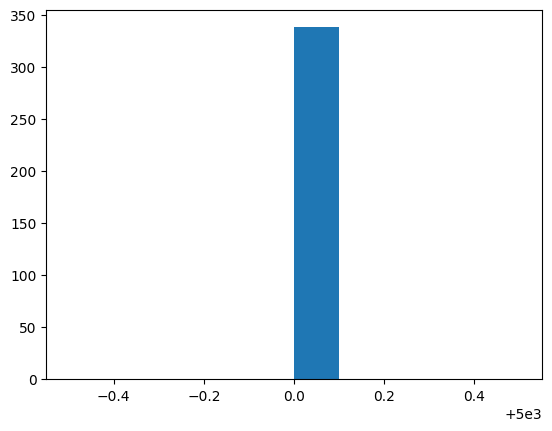

In [9]:
dates_lower= [data[k].index[0] for k in data if data[k].index[0].date()==datetime(2021,11,9).date()]
print(len(dates_lower))
plt.hist([len(data[k]) for k in data if data[k].index[0].date()==datetime(2021,11,9).date()],bins=10)

In [10]:
data = {k: v for k, v in data.items() if data[k].index[0].date()==datetime(2021,11,9).date()}

In [11]:
list(data.keys())[250:270]

['FDX',
 'FE',
 'FHI',
 'FHN',
 'FIGS',
 'FIS',
 'FL',
 'FLO',
 'FLR',
 'FMX',
 'FNB',
 'FND',
 'FNF',
 'FNV',
 'FOUR',
 'FREY',
 'FRO',
 'FSK',
 'FSLY',
 'FSM']

In [119]:
ticker = 'FE'

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


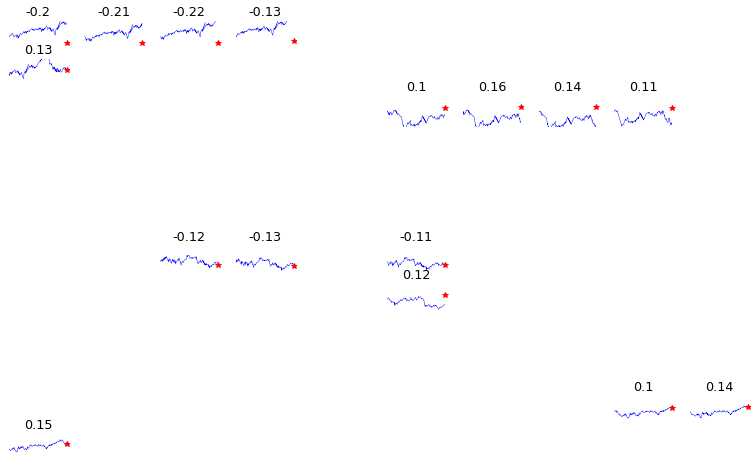

In [128]:


labels = np.array(data[ticker].close[435:]/data[ticker].close[4:len(data[ticker])-431].values-1)
xaxis_close = np.linspace(0,len(data[ticker])-1-431,len(data[ticker])-431)
xaxis_labels = np.linspace(0,len(labels)-1,len(labels))

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[ticker].close.values.reshape(-1, 1))

price_max = data_scaled.max()
price_min = data_scaled.min()
st = 5 #stride in days
rng = 90 #dataRange in days
prd = 10 #predictionPeriod in days
h4d = 7
targetBuffer = 10 #time periods
minRelativePriceMove = 0.1

fig, axs = plt.subplots(12,10,figsize=(15,9), dpi=64)
#fig, axs = plt.subplots(3,3,figsize=(15,9), dpi=64)
xmax = data[ticker].close.max()
for i,ax in enumerate(axs.flatten()):
  target = np.mean(labels[i*h4d*st+h4d*rng+h4d*prd-targetBuffer:i*h4d*st+h4d*rng+h4d*prd+targetBuffer]) #stride + dataRange+ predictionPeriod +-1day (=20 hours)
  if target>minRelativePriceMove or target<-minRelativePriceMove:
    # Plot on the primary y-axis
    priceFix = 0.5-data_scaled[i*h4d*st]
    ax.plot(xaxis_close[i*h4d*st:h4d*rng+h4d*st*i], data_scaled[i*h4d*st:h4d*rng+h4d*st*i]+priceFix, 'b-', label='close',linewidth=0.5)
    ax.set_ylim(0.1,0.9)
    #ax.set_ylim(np.min(data_scaled[i*10:90+10*i]+priceFix),np.max(data_scaled[i*10:90+10*i]+priceFix))
    # Create the secondary y-axis
    ax2 = ax.twinx()
    #ax2.plot(xaxis_labels[i*10:90+10*i], labels[i*10:90+10*i], 'r-', label='labels',linewidth=0.5)
    ax2.plot(xaxis_labels[h4d*rng+h4d*st*i], target, 'r*', label='labels',linewidth=0.5)
    ax2.set_ylim(-0.5,0.5)
    ax.set_title(round(target,2))

    # Remove plot frame
  ax.axis('off')
  ax2.axis('off')

plt.show()

In [14]:
print(data['DT'].index[4].time()) # need to remove first 4 time point so data would start at end of day
print(data['DT'].index[431+4].time()) #431 time points is is equal to 90 days
print(data['DT'].index[4].date()) # need to remove first 4 time point so data would start at end of day
print(data['DT'].index[431+4].date()) #431 time points is is equal to 90 days


16:30:00
16:30:00
2021-11-10
2022-02-09


In [15]:
print(data['DT'].index[25].time())

16:30:00


In [16]:
len(labels)

4565

In [17]:
len(data['DT'].close[4:len(data['DT'])-431])

4565

In [18]:
xaxis_close = np.linspace(0,len(data['DT'])-1-431,len(data['DT'])-431)
xaxis_labels = np.linspace(0,len(labels)-1,len(labels))

In [19]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data['DT'].close.values.reshape(-1, 1))

price_max = data_scaled.max()
price_min = data_scaled.min()

AttributeError: 'Axes' object has no attribute 'flatten'

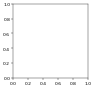

In [20]:

fig, axs = plt.subplots(1,1,figsize=(3,3), dpi=32)
xmax = data['DT'].close.max()
for i,ax in enumerate(axs.flatten()):
  # Plot on the primary y-axis
  priceFix = 0.5-data_scaled[i*10]
  ax.plot(xaxis_close[i*10:90+10*i], data_scaled[i*10:90+10*i]+priceFix, 'b-', label='close',linewidth=0.5)
  #ax.set_xlabel('X axis')
  #ax.set_ylabel('price', color='b')
  #ax.tick_params(axis='y', labelcolor='b')
  ax.set_ylim(0.15,0.85)

  #ax.set_ylim(np.min(data_scaled[i*10:90+10*i]+priceFix),np.max(data_scaled[i*10:90+10*i]+priceFix))
  # Create the secondary y-axis
  ax2 = ax.twinx()
  #ax2.plot(xaxis_labels[i*10:90+10*i], labels[i*10:90+10*i], 'r-', label='labels',linewidth=0.5)
  ax2.plot(xaxis_labels[90+10*i], np.mean(labels[90+10*i-5:90+10*i+5]), 'r*', label='labels',linewidth=0.5)
  ax2.set_ylim(-0.5,0.5)
  #ax2.set_xlabel('X axis'
  #ax2.set_ylabel('labels', color='r')
  #ax2.tick_params(axis='y', labelcolor='r')


  # Remove plot frame
  ax.axis('off')
  ax2.axis('off')
  # Show plot with a legend for both axes
  #ax1.legend(loc='upper left')
  #ax2.legend(loc='upper right')




plt.show()

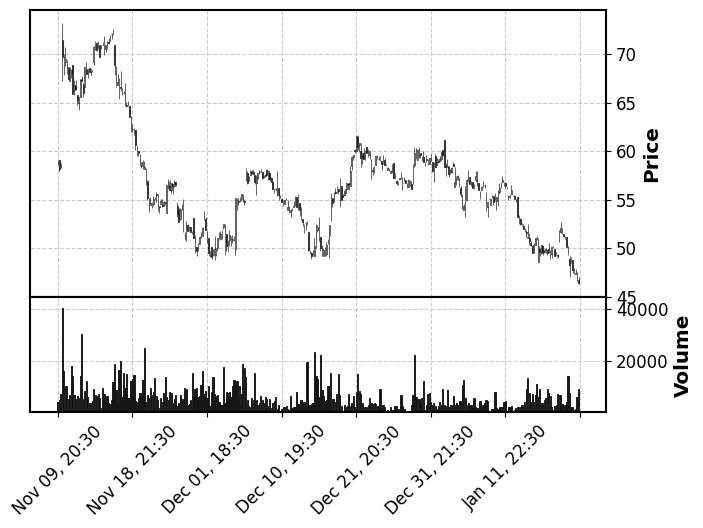

In [53]:
i=0
# Define a custom grayscale style without gridlines

# Create a custom style without gridlines and in grayscale
custom_style = mpf.make_mpf_style(base_mpf_style='charles', facecolor='white', gridstyle='')  # No gridlines

# Plot candlestick chart with custom style
mpf.plot(data[ticker][i*7*5:5*70+7*5*i], type='candle', volume=True, style='classic')




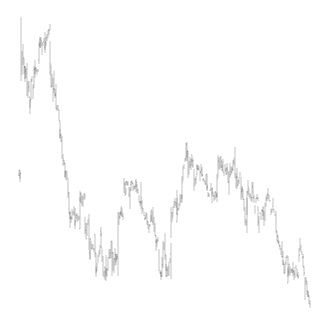

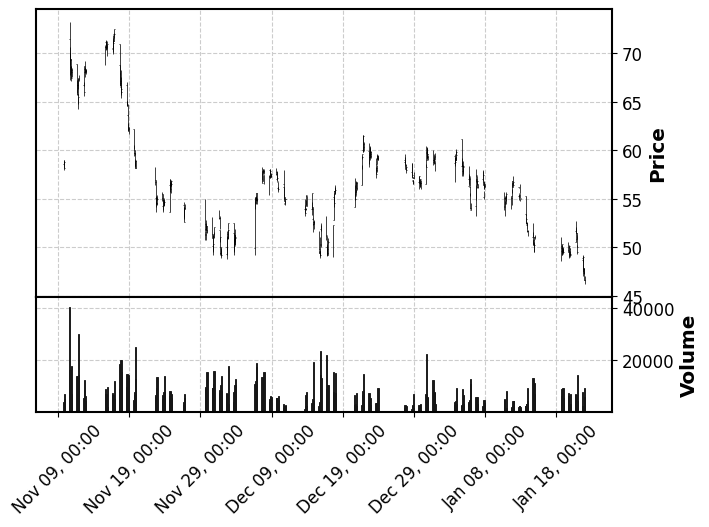

AttributeError: module 'mplfinance' has no attribute 'xaxis'

In [69]:
fig, ax = plt.subplots(figsize=(13,13), dpi=32)

mpf.plot(data[ticker][i*7*5:5*70+7*5*i], type='ohlc', ax=ax,style='classic', returnfig=True)#, grid=False)

# Remove gridlines (already done by grid=False in the mpf.plot call)

# Remove the x-axis ticks and labels
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

# Remove the borders (spines)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

mpf.plot(data[ticker][i*7*5:5*70+7*5*i],
         type='ohlc',
         volume=True,
         style='classic',
         show_nontrading=True)
# Remove the x-axis ticks and labels
mpf.xaxis.set_visible(False)
mpf.yaxis.set_visible(False)

# Remove the borders (spines)
mpf.spines['top'].set_visible(False)
mpf.spines['bottom'].set_visible(False)
mpf.spines['left'].set_visible(False)
mpf.spines['right'].set_visible(False)
plt.show()
plt.show()

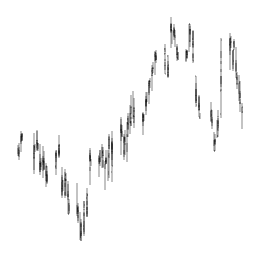

(160, 160, 4)


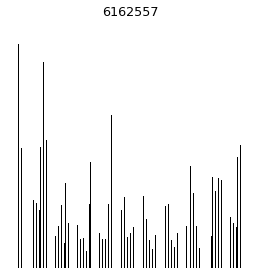

In [126]:
import mplfinance as mpf
import matplotlib.pyplot as plt

# Assuming data[ticker] is your OHLCV data (OHLC + Volume), indexed by date
ticker_data = data[ticker][i*7*5:5*70+7*5*i]
dpi = 64
figsize = (5, 5)
# --------------------------------------------
# Plot 1: OHLC Price Action Only
fig1, ax1 = plt.subplots(figsize=figsize,dpi=dpi)

# Plot the OHLC chart without volume
mpf.plot(ticker_data,
         type='ohlc',
         ax=ax1,
         volume=False,
         style='classic',
         show_nontrading=True)

# Customize Plot 1: Remove gridlines, ticks, and borders
ax1.xaxis.set_visible(False)
ax1.yaxis.set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['right'].set_visible(False)
plt.show()
fig1.canvas.draw()
buffer = fig1.canvas.tostring_argb()
image_array1 = np.frombuffer(buffer, dtype=np.uint8).reshape((figsize[0]*dpi, figsize[0]*dpi, -1))
print(image_array.shape)
fig1.savefig(savePath+'teat_output1.png', dpi=dpi)
# --------------------------------------------
# Plot 2: Volume Only (with matplotlib)
fig2, ax2 = plt.subplots(figsize=figsize,dpi=dpi)

# Extract the volume data and corresponding dates
volume_data = ticker_data['cap']
volume_dates = ticker_data.index

# Plot the volume as a bar chart
ax2.bar(volume_dates, volume_data, color='black', width=0.1)

# Customize Plot 2: Remove gridlines, ticks, and borders
ax2.xaxis.set_visible(False)
ax2.yaxis.set_visible(False)
ax2.set_title(int(np.max(volume_data)))
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Display both figures
plt.show()
fig2.canvas.draw()
buffer = fig2.canvas.tostring_argb()
image_array2 = np.frombuffer(buffer, dtype=np.uint8).reshape((figsize[0]*dpi, figsize[0]*dpi, -1))
image_array2 = image_array2[:,:,1]
pickle.dump(image_array2,open(savePath+'teat_output2_array.pickle','wb'))
fig2.savefig(savePath+'teat_output1.png', dpi=dpi)

#plt.imshow(image_array[:,:,1],cmap='gray')
plt.show()
image_array1 = image_array1[:,:,1]
pickle.dump(image_array1,open(savePath+'teat_output1_array.pickle','wb'))

twoChan = np.concatenate((image_array1[:, :, np.newaxis], image_array2[:, :, np.newaxis]), axis=2)

#plt.imshow(twoChan)
plt.show()
pickle.dump(twoChan,open(savePath+'teat_output_2chan.pickle','wb'))


HBM
HCA
100 :  105.99947690963745
HCC
HD
200 :  211.8188807964325
HDB
HES
300 :  316.82692766189575
HIG
HIMS
400 :  423.03993940353394
HIW
500 :  528.8925044536591
HL
10 tickers :  622.7692601680756


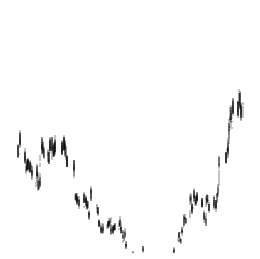

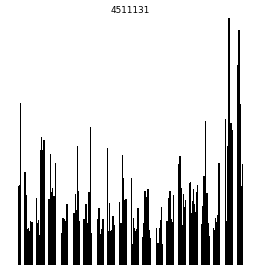

In [240]:
from copy import deepcopy
import warnings
import time
warnings.filterwarnings('ignore')


scaledDF = deepcopy(data[ticker])
scaledDF = scaledDF.iloc[:,1:5]

st = 5 #stride in days
rng = 90 #dataRange in days
prd = 10 #predictionPeriod in days
h4d = 7
targetBuffer = 10 #time periods
minRelativePriceMove = 0.1
dpi = 64
figsize = (5, 5)
nTickers= 10
nPics4Ticker = 110

nTotalPics = nTickers*nPics4Ticker
imageData = np.zeros((nTotalPics,dpi*figsize[0],dpi*figsize[0],2))

fig1, ax1 = plt.subplots(figsize=figsize,dpi=dpi)

fig2, ax2 = plt.subplots(figsize=figsize,dpi=dpi)


count = 0
indicesNotUsed=[]
start_time = time.time()
for j,ticker in enumerate(list(data.keys())[300:300+nTickers]):
  print(ticker)
  labels = np.array(data[ticker].close[435:]/data[ticker].close[4:len(data[ticker])-431].values-1)
  xaxis_close = np.linspace(0,len(data[ticker])-1-431,len(data[ticker])-431)
  xaxis_labels = np.linspace(0,len(labels)-1,len(labels))

  # Extract the volume data and corresponding dates
  volume_data = data[ticker]['cap'].values
  volume_dates = data[ticker].index


  #fig, axs = plt.subplots(12,10,figsize=(15,9), dpi=64) #120 for ALL time points, need to remove last ten so as to not to contaminate when testing

  for i in range(nPics4Ticker):
    target = np.mean(labels[i*h4d*st+h4d*rng+h4d*prd-targetBuffer:i*h4d*st+h4d*rng+h4d*prd+targetBuffer]) #stride + dataRange+ predictionPeriod +-1day (=20 hours)
    if target>minRelativePriceMove or target<-minRelativePriceMove:
      count+=1
      #print(target)
      scaler = MinMaxScaler()
      scaledDF.iloc[:,:] = scaler.fit_transform(data[ticker].iloc[:,1:5].values)
      # Plot on the primary y-axis
      priceFix = 0.5/scaledDF.iloc[i*h4d*st,0] #to make the first opening value to be 0.5
      scaledDF *= priceFix

      # Plot the OHLC chart without volume
      ax1.clear()
      mpf.plot(scaledDF.iloc[i*h4d*st:h4d*rng+h4d*st*i,:],
              type='ohlc',
              ax=ax1,
              volume=False,
              style='classic',
              show_nontrading=True)

      # Customize Plot 1: Remove gridlines, ticks, and borders
      # ax1.axis('off')
      ax1.set_ylim(0.1,1.1)
      ax1.xaxis.set_visible(False)
      ax1.yaxis.set_visible(False)
      ax1.spines['top'].set_visible(False)
      ax1.spines['bottom'].set_visible(False)
      ax1.spines['left'].set_visible(False)
      ax1.spines['right'].set_visible(False)
      #plt.show()


      fig1.canvas.draw()
      rgba_array = np.frombuffer(fig1.canvas.tostring_argb(), dtype=np.uint8).reshape((figsize[0]*dpi, figsize[0]*dpi, 4))
      #grey_array = 0.2989 * rgba_array[..., 0] + 0.5870 * rgba_array[..., 1] + 0.1140 * rgba_array[..., 2]
      imageData[j,:,:,0] = (0.2989 * rgba_array[..., 0] + 0.5870 * rgba_array[..., 1] + 0.1140 * rgba_array[..., 2])/255
      # plt.imshow(grey_array,cmap='gray')
      # plt.show()


      # Plot 2: Volume Only (with matplotlib)
      ax2.clear()
      ax2.bar(volume_dates[i*h4d*st:h4d*rng+h4d*st*i], volume_data[i*h4d*st:h4d*rng+h4d*st*i], color='black', width=0.75)

      # Customize Plot 2: Remove gridlines, ticks, and borders

      #ax2.axis('off')
      ax2.set_ylim(0,np.max(volume_data[i*h4d*st:h4d*rng+h4d*st*i]))
      ax2.set_title(int(np.max(volume_data[i*h4d*st:h4d*rng+h4d*st*i])),fontsize=10)
      ax2.xaxis.set_visible(False)
      ax2.yaxis.set_visible(False)
      ax2.spines['top'].set_visible(False)
      ax2.spines['bottom'].set_visible(False)
      ax2.spines['left'].set_visible(False)
      ax2.spines['right'].set_visible(False)

      #plt.show()

      fig2.canvas.draw()
      rgba_array = np.frombuffer(fig2.canvas.tostring_argb(), dtype=np.uint8).reshape((figsize[0]*dpi, figsize[0]*dpi, 4))
      #grey_array = 0.2989 * rgba_array[..., 0] + 0.5870 * rgba_array[..., 1] + 0.1140 * rgba_array[..., 2]
      imageData[j,:,:,1] = (0.2989 * rgba_array[..., 0] + 0.5870 * rgba_array[..., 1] + 0.1140 * rgba_array[..., 2])/255

      if count%100 ==0:
        print(count,': ',time.time()-start_time)
  else:
    indicesNotUsed.append(i)
print('10 tickers : ',time.time()-start_time)


In [48]:
data[ticker][i*7*5:5*70+7*5*i].head()

,symbol,open,high,low,close,volume,cap,wide_range,narrow_range/wide_range
datetime,,,,,,,,,
2021-11-09 20:30:00,NYSE:FOUR,58.60,59.04,58.53,58.990,4000.0,235960.00,0.008703,0.764706
2021-11-09 21:30:00,NYSE:FOUR,59.06,59.06,58.00,58.180,5000.0,290900.00,0.017948,0.830189
2021-11-09 22:30:00,NYSE:FOUR,58.22,58.80,58.22,58.775,7000.0,411425.00,0.009962,0.956897
2021-11-10 16:30:00,NYSE:FOUR,71.47,73.21,67.27,69.750,40426.0,2819713.50,0.083112,0.289562
2021-11-10 17:30:00,NYSE:FOUR,70.00,70.05,67.82,69.340,16119.0,1117691.46,0.031857,0.295964


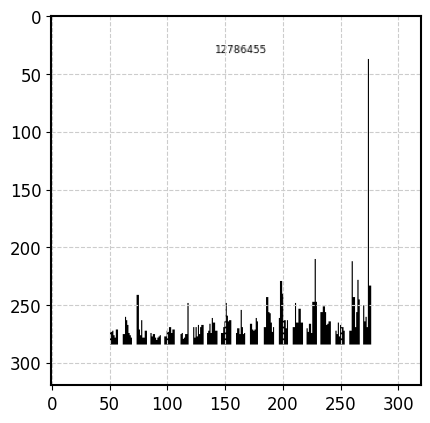

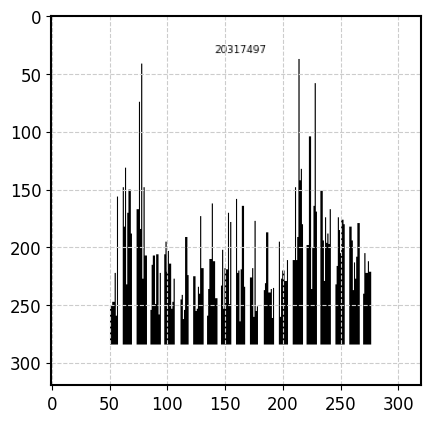

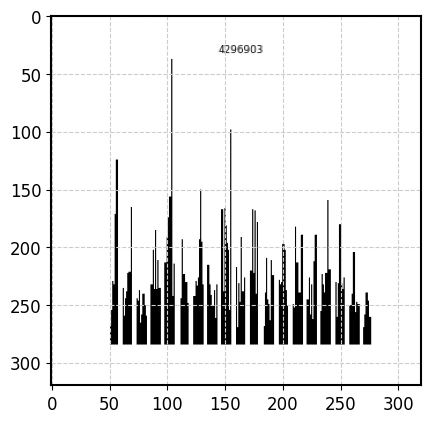

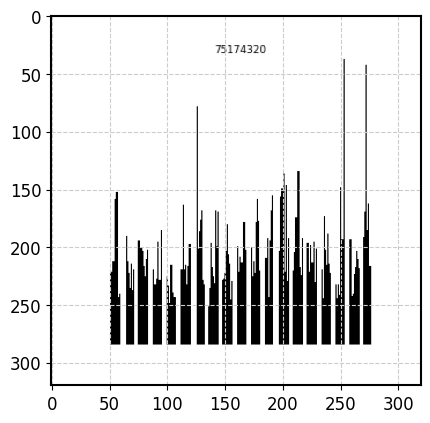

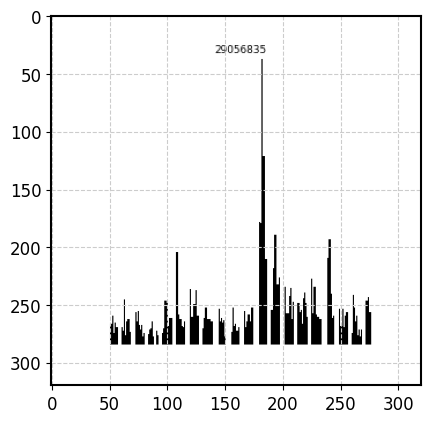

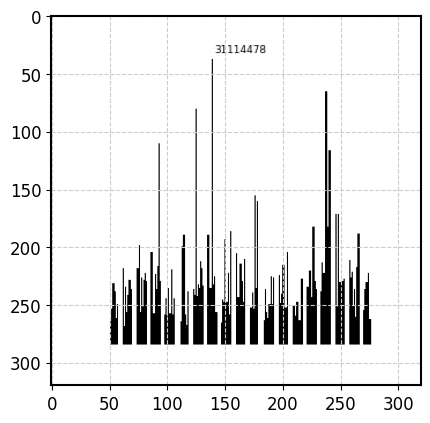

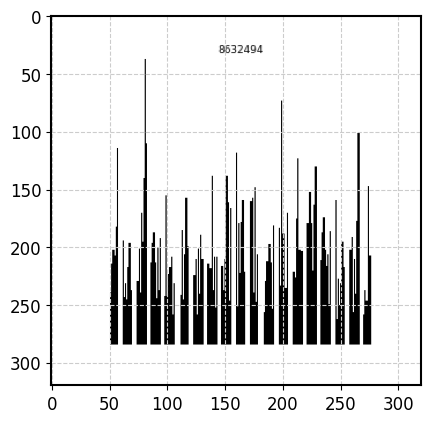

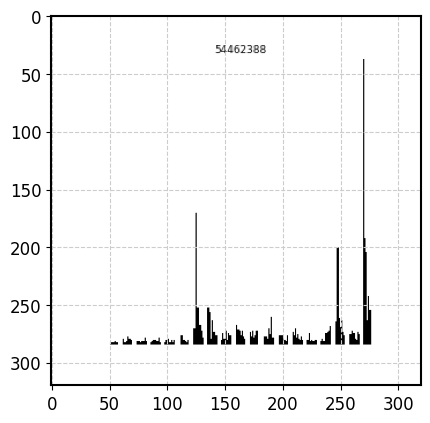

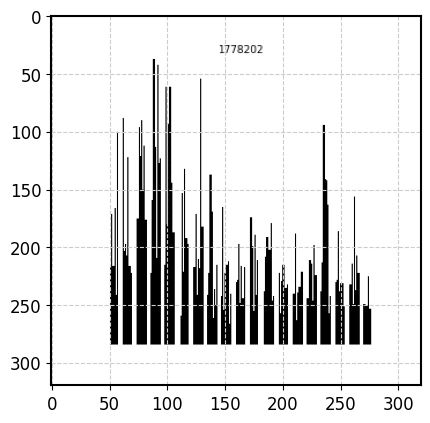

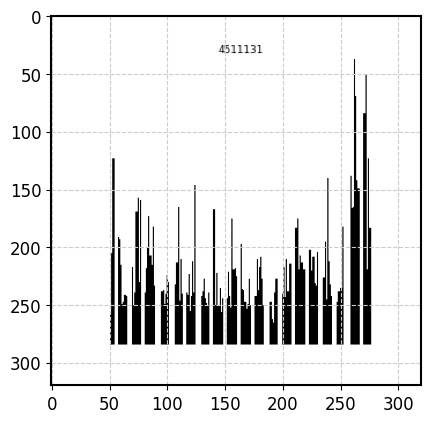

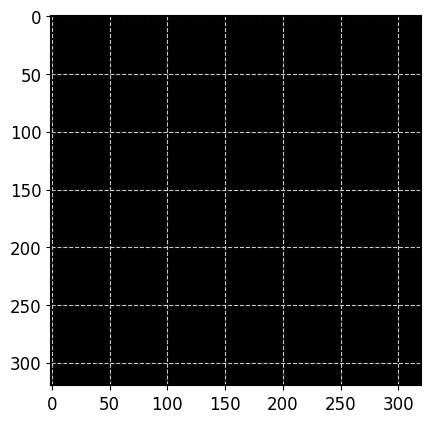

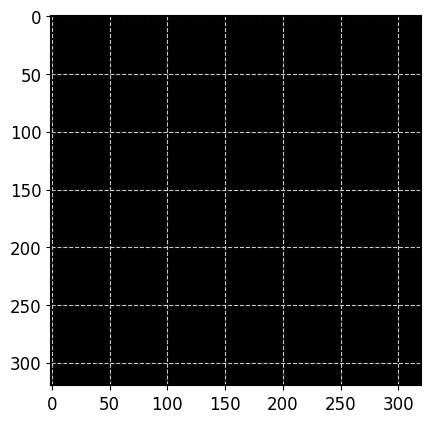

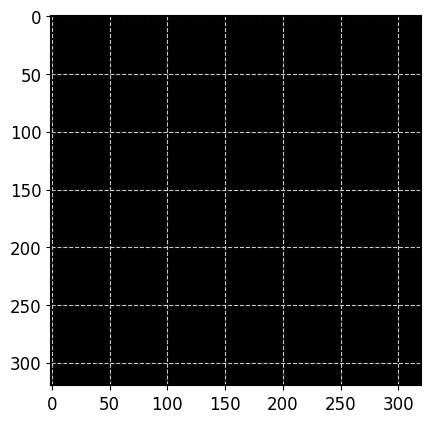

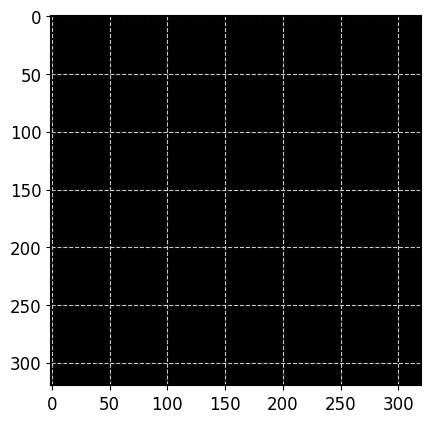

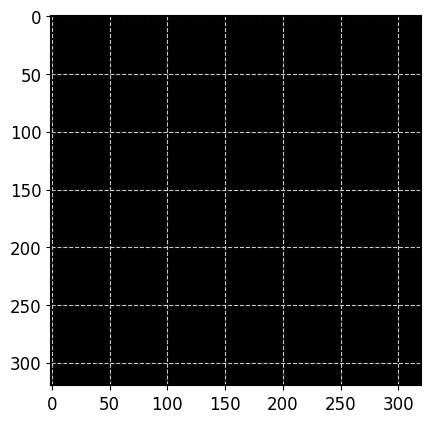

KeyboardInterrupt: 

In [242]:
for i in range(100):
  plt.imshow(imageData[i,:,:,1],cmap='gray')
  plt.show()

In [190]:
i=40
np.max(volume_data.iloc[i*h4d*st:h4d*rng+h4d*st*i])

7556330.6

In [140]:
from copy import deepcopy
scaler = MinMaxScaler()
scaledDF = deepcopy(data[ticker])
scaledDF.iloc[:,1:5] = scaler.fit_transform(data[ticker].iloc[:,1:5].values)

In [141]:
scaledDF = scaledDF.iloc[:,1:5]
scaledDF.iloc[:,:] = scaler.fit_transform(data[ticker].iloc[:,1:5].values)
scaledDF.head()


,open,high,low,close
datetime,,,,
2021-11-09 20:30:00,0.352252,0.342848,0.362859,0.352905
2021-11-09 21:30:00,0.353486,0.355259,0.367746,0.352287
2021-11-09 22:30:00,0.355028,0.345951,0.358583,0.355995
2021-11-10 16:30:00,0.370142,0.380081,0.381796,0.383189
2021-11-10 17:30:00,0.384948,0.374496,0.387294,0.376391


In [38]:
pip install --upgrade mplfinance

In [ ]:
plt.plot(xaxis_close,data['DT'].close)
plt.plot(xaxis_labels,labels)

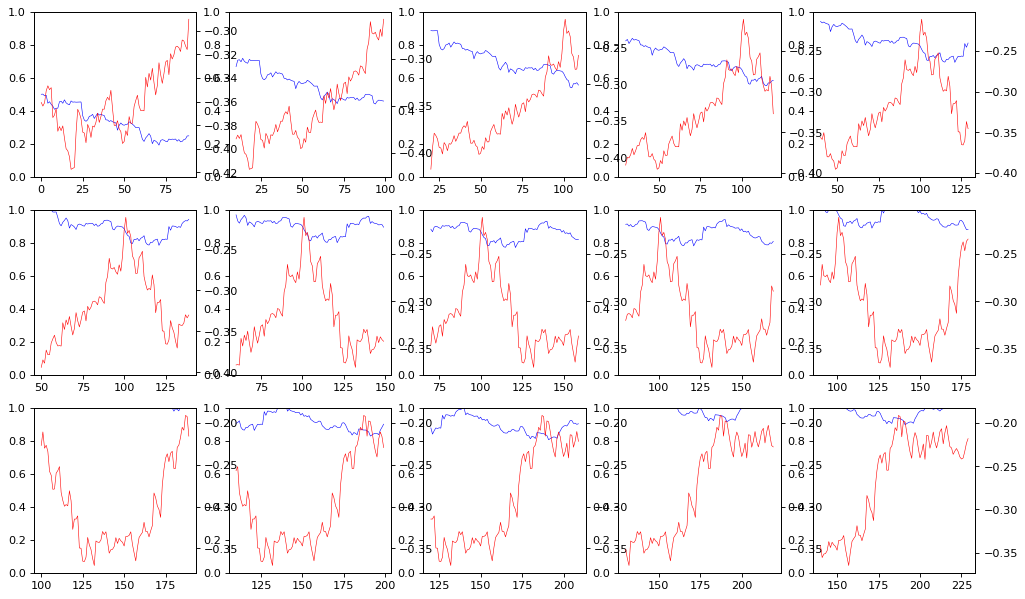

In [46]:

fig, axs = plt.subplots(3,5,figsize=(15,9), dpi=81)
xmax = data['DT'].close.max()
for i,ax in enumerate(axs.flatten()):
  # Plot on the primary y-axis
  priceFix = 0.5-data_scaled[i*90]
  ax.plot(xaxis_close[i*10:90+10*i], data_scaled[i*10:90+10*i]+priceFix, 'b-', label='close',linewidth=0.5)
  #ax.set_xlabel('X axis')
  #ax.set_ylabel('price', color='b')
  #ax.tick_params(axis='y', labelcolor='b')
  ax.set_ylim(price_min,price_max)

  #ax.set_ylim(np.min(data_scaled[i*10:90+10*i]+priceFix),np.max(data_scaled[i*10:90+10*i]+priceFix))
  # Create the secondary y-axis
  ax2 = ax.twinx()
  ax2.plot(xaxis_labels[i*10:90+10*i], labels[i*10:90+10*i], 'r-', label='labels',linewidth=0.5)

  #ax2.set_xlabel('X axis'
  #ax2.set_ylabel('labels', color='r')
  #ax2.tick_params(axis='y', labelcolor='r')

  # Show plot with a legend for both axes
  #ax1.legend(loc='upper left')
  #ax2.legend(loc='upper right')


plt.show()

In [10]:

def loadAndCombineData(all_data,savePath,exchange,start_idx,interval,end_idx,day,month,year):
  print(exchange)
  date = str(day)+str(month)+str(year)
  for idx in range(start_idx,end_idx+interval,interval):
    with open(savePath+'TVstockData_'+exchange+'_'+date+'_'+str(idx)+'.pickle', 'rb') as file:
        data = pd.read_pickle(file)
    all_data = {**all_data, **data}
  return(all_data)

savePath ='/content/drive/MyDrive/myStocksSept2024/'

date = str(18)+str(9)+str(2024)
with open(savePath+'TVstockData_NASDAQ_'+date+'_1000.pickle', 'rb') as file:
        nasdaq_data = pd.read_pickle(file)
print(len(nasdaq_data))
nasdaq_data = loadAndCombineData(nasdaq_data,savePath,'NASDAQ',1000,100,3700,18,9,2024)
print(len(nasdaq_data))
nasdaq_data = loadAndCombineData(nasdaq_data,savePath,'NASDAQ',3800,100,4800,20,9,2024)
print(len(nasdaq_data))
date = str(20)+str(9)+str(2024)
with open(savePath+'TVstockData_NASDAQ_'+date+'_final_4803.pickle', 'rb') as file:
        current_data = pd.read_pickle(file)
nasdaq_data = {**nasdaq_data, **current_data}
print(len(nasdaq_data))

with open(savePath+'TVstockData_NASDAQ_all_4803_18-20Sept2024.pickle', 'wb') as file:
        pickle.dump(nasdaq_data,file)

nyse_data = loadAndCombineData({},savePath,'NYSE',1000,1000,6000,17,9,2024)
print(len(nyse_data))
date = str(17)+str(9)+str(2024)
with open(savePath+'TVstockData_NYSE_'+date+'_final_6293.pickle', 'rb') as file:
        current_data = pd.read_pickle(file)
nyse_data = {**nyse_data, **current_data}
print(len(nyse_data))

with open(savePath+'TVstockData_NYSE_all_6293_17Sept2024.pickle', 'wb') as file:
        pickle.dump(nyse_data,file)

data = { **nasdaq_data,**nyse_data}
print(len(data))

675
NASDAQ
2709
NASDAQ
3475
3477
NYSE
2282
2373
5850
